# Load the Data

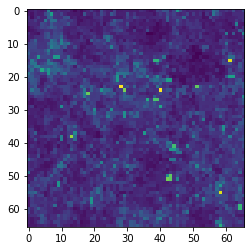

# samples used for training: 80000
# samples used for validation: 10000
# samples used for testing: 10000
# total samples: 100000
(80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
(80000, 6) (10000, 6) (10000, 6)


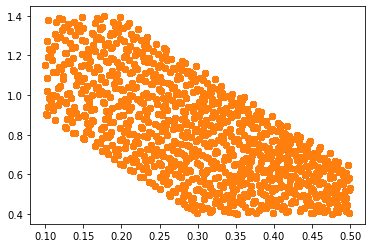

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# load cosmological parameters -------
# Omega_m, H0, ns, sigma_8, w, omega_b
Yvals = np.load("/global/cfs/cdirs/des/shubh/transformers/ViT_weak_lensing/data/6-parameter-maps/y_maps_Cosmogrid_100k.npy", allow_pickle=True)

# patches
Xvals = np.load("/global/cfs/cdirs/des/shubh/transformers/ViT_weak_lensing/data/6-parameter-maps/X_maps_Cosmogrid_100k.npy", allow_pickle=True)

# show a patch -----
plt.imshow(Xvals[0])
plt.show()

# number of samples
num_samples = len(Yvals)

# split the sample for training ----------
train_split, val_split, test_split = int(0.80*num_samples), \
            int(0.10*num_samples), int(0.10*num_samples)
    
print('# samples used for training:', train_split)
print('# samples used for validation:', val_split)
print('# samples used for testing:' ,test_split)
print('# total samples:', train_split+val_split+test_split)


train_x, val_x, test_x = np.split(Xvals, [train_split, train_split+val_split])
train_y, val_y, test_y = np.split(Yvals, [train_split, train_split+val_split])

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)


params_mask = np.array([True,False,False,True,False,False])
output_num = len(params_mask[params_mask])

# let's focus on omega_m and sigma_8 
train_y, val_y, test_y = train_y[:,params_mask], val_y[:,params_mask], test_y[:,params_mask]

plt.scatter(train_y[:,0],train_y[:,1])
plt.scatter(val_y[:,0],val_y[:,1])

In [2]:
np.save('test_x',test_x)
np.save('test_y',test_y)


# define your model

In [3]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=4)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1200, 128)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu6 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, output_num)
        
    def forward(self, x):
        # x = self.normalization(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        return x

model = Model()

# Print the model summary
print(model)


Model(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(4, 4), stride=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1200, out_features=128, bias=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu5): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu6): LeakyReLU(negative_slope=0.01)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [5]:
# Convert data into torch format
import torch
import torch.nn as nn
import torch.optim as optim
epochs = 10
batch_size = 8

# Create DataLoader for batching the data
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_x[:, None, :, :]), torch.from_numpy(train_y[:]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_x[:, None, :, :]), torch.from_numpy(val_y))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_x[:, None, :, :]), torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# train

In [ ]:
import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, 
                data_loader, 
                val_loader,
                dataset_size, 
                val_size, 
                optimizer, 
                num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        model.train()

        running_loss = 0.0
        # Iterate over data.
        for bi, (inputs, labels) in enumerate(tqdm.tqdm(train_loader)):
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        if epoch % 10 == 0:
            print('Loss: {:.4f}'.format(epoch_loss))
        
        if epoch % 10 == 0:
            model.eval()
            running_loss = 0.0
            # Iterate over data.
            for bi, (inputs, labels) in enumerate(tqdm.tqdm(val_loader)):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                with torch.no_grad():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
            epoch_val_loss = running_loss / val_size
            print('Val Loss: {:.4f}'.format(epoch_val_loss))
    return model

learning_rate = 0.001
weight_decay_rate = 0.01

optimizer = optim.AdamW(model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay_rate)

model = train_model(model, train_loader, val_loader, len(train_y), len(val_y), optimizer, 100)

  0%|          | 5/10000 [00:00<03:38, 45.81it/s]

Epoch 0/99
----------


  1%|▏         | 16/1250 [00:00<00:07, 159.51it/s]

Loss: 0.0139


  0%|          | 4/10000 [00:00<04:43, 35.26it/s]

Val Loss: 0.0069


 59%|█████▉    | 5886/10000 [01:40<01:10, 58.30it/s]

In [11]:
torch.save(model.state_dict(), './CNN_mass_maps.pth')


In [23]:
model1 = torch.load('./CNN_mass_maps.pth')


# predict

100%|██████████| 1250/1250 [00:07<00:00, 167.18it/s]


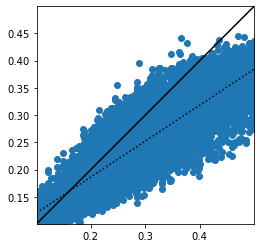

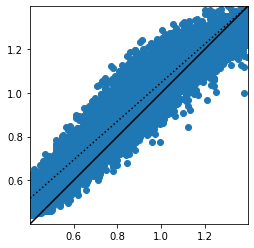

In [6]:

preds = np.empty((len(val_y), output_num))

model.eval()
for bi, (inputs, labels) in enumerate(tqdm.tqdm(val_loader)):
    inputs = inputs.to(device, dtype=torch.float)
    outputs = model(inputs)
    preds[bi*8 : (1+bi)*8] = outputs.detach().cpu().numpy()
        
preds.shape

plot_x, plot_y =val_x, val_y
predictions = preds
upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)

# Visualize predictions
for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    plt.figure()
    plt.scatter(plot_y[:, ind], predictions[:, ind])
    plt.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    plt.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    plt.xlim([low_lim, upp_lim])
    plt.ylim([low_lim, upp_lim])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    plt.close()

    